In [1]:
# librerias para manejo de datos
import os
import glob
import numpy as np
import pandas as pd

# librerias para Kmeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# librerias para estimar la similitud del coseno
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# otros
import warnings
warnings.filterwarnings('ignore')

In [2]:
# carga de datos
# quitamos lo valores nulos en 'overview'
data_mvp_ml = pd.read_csv(os.path.join('3_output','data_mvp_final_ml.csv'),index_col=0).convert_dtypes().dropna() 
print("Universo de peliculas unicas:",data_mvp_ml['pelicula_id'].nunique())
data_mvp_ml.info()
data_mvp_ml.isna().sum()

Universo de peliculas unicas: 35834
<class 'pandas.core.frame.DataFrame'>
Index: 42054 entries, 0 to 93359
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   original_language     42054 non-null  string 
 1   title                 42054 non-null  string 
 2   release_year          42054 non-null  Int64  
 3   pelicula_id           42054 non-null  Int64  
 4   genres                42054 non-null  string 
 5   prtgnst_nivel         42054 non-null  Int64  
 6   vote_average          42054 non-null  Float64
 7   prtgnst_gender_strng  42054 non-null  string 
 8   popularity            42054 non-null  Float64
 9   overview              42054 non-null  string 
dtypes: Float64(2), Int64(3), string(5)
memory usage: 3.7 MB


original_language       0
title                   0
release_year            0
pelicula_id             0
genres                  0
prtgnst_nivel           0
vote_average            0
prtgnst_gender_strng    0
popularity              0
overview                0
dtype: int64

In [3]:
# definimos nuestro la jerarquia de clusters.
vars_clstr_a=[
    'popularity',
    'release_year'
    ]
vars_clstr_b=[
    'genres',
    'prtgnst_gender_strng',
    'vote_average'
    ]
#vars_clstr_c=[
#    'franquicia',
#    'original_language'#,
    #'director', # excluimos por cantidad de valores unicos
    #'executive_producer'
#    ]

In [4]:
#data_mvp_ml_indexed=data_mvp_ml.dropna().set_index('pelicula_id')

# filtramos 'prtgnst_nivel' == 1; es decir, en el genero del protagonista (excluimos actores secundarios)
#data_mvp_ml_indexed=data_mvp_ml_indexed.loc[data_mvp_ml_indexed['prtgnst_nivel'].isin([1])]
#data_mvp_ml=data_mvp_ml_indexed.reset_index()
#data_mvp_ml['pelicula_id'].nunique()

In [5]:
data_mvp_ml_clstr_a=data_mvp_ml[['pelicula_id']+vars_clstr_a].drop_duplicates()
print(data_mvp_ml_clstr_a['pelicula_id'].nunique())
data_mvp_ml_clstr_a.set_index('pelicula_id', inplace=True)
data_mvp_ml_clstr_a.info()
data_mvp_ml_clstr_a.head(3)

35834
<class 'pandas.core.frame.DataFrame'>
Index: 35834 entries, 862 to 227506
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    35834 non-null  Float64
 1   release_year  35834 non-null  Int64  
dtypes: Float64(1), Int64(1)
memory usage: 944.8 KB


,popularity,release_year
pelicula_id,,
862,21.946943,1995
8844,17.015539,1995
15602,11.7129,1995


In [6]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(data_mvp_ml_clstr_a)
data_mvp_ml_clstr_a_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_a),
    index=data_mvp_ml_clstr_a.index).rename(columns={0: "popularity_scaled", 1: "release_year_scaled"})
data_mvp_ml_clstr_a_scaled.head()

,popularity_scaled,release_year_scaled
pelicula_id,,
862,0.040087,0.810606
8844,0.031079,0.810606
15602,0.021394,0.810606
31357,0.007049,0.810606
11862,0.015320,0.810606


In [7]:
# SSE corresponde a Suma de distancias al cuadrado; es el equivalente al "residual" en regresion lineal.
# Interpretacion de SEE: entre mas bajo, cada registro esta mas cerca al centro del cluster mas cercano
sse = [] 
random_state=42
#KMeans(n_clusters=2, random_state=42)
for k in range(1, 36): # escogemos 36 para generar clusters con un promedio de 1000 registros c/u.
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(data_mvp_ml_clstr_a_scaled)
    sse.append(kmeans.inertia_) # este es nuestro SSE

# identificamos el numero optimo de clusters
kl_eval = KneeLocator(range(1, 36), sse, curve="convex", direction="decreasing")

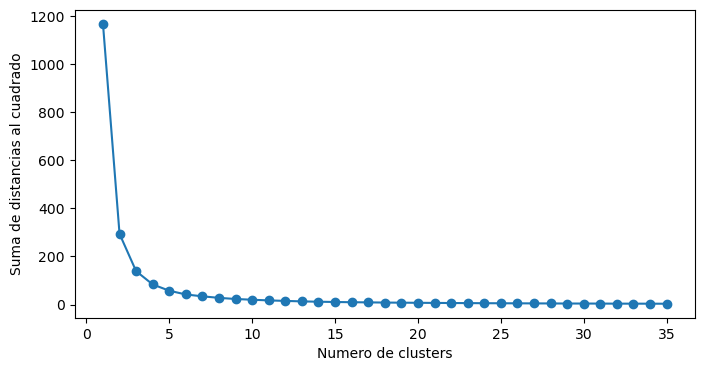

Numero optimo de clusters: 4


In [8]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 36), sse, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de distancias al cuadrado')
plt.show()
k_optimo_clstr_a=kl_eval.elbow
print("Numero optimo de clusters:", k_optimo_clstr_a)

In [9]:
kmeans_clstr_a = KMeans(n_clusters=k_optimo_clstr_a, random_state=random_state)
kmeans_clstr_a.fit(data_mvp_ml_clstr_a_scaled)
data_mvp_ml_clstr_a_scaled['clstr_a'] = kmeans_clstr_a.predict(data_mvp_ml_clstr_a_scaled)+1
data_mvp_ml_clstr_a_scaled.reset_index(inplace=True)
data_mvp_ml_clstr_a_scaled.info()
data_mvp_ml_clstr_a_scaled.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35834 entries, 0 to 35833
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pelicula_id          35834 non-null  Int64  
 1   popularity_scaled    35834 non-null  float64
 2   release_year_scaled  35834 non-null  float64
 3   clstr_a              35834 non-null  int32  
dtypes: Int64(1), float64(2), int32(1)
memory usage: 1015.0 KB


,pelicula_id,popularity_scaled,release_year_scaled,clstr_a
0,862,0.040087,0.810606,1
1,8844,0.031079,0.810606,1
2,15602,0.021394,0.810606,1
3,31357,0.007049,0.810606,1
4,11862,0.015320,0.810606,1


In [10]:
data_mvp_ml_dummies_genres = pd.get_dummies(
    data=data_mvp_ml[['pelicula_id','genres']].drop_duplicates().set_index('pelicula_id'),
    columns=['genres'], # genera dummies para cada grupo de valor por columna:
    drop_first=True, # elimina las variables reduntantes por columna
    dtype=float # dummies en valore numerico
    ).reset_index()

# Como nuestro objetivo es medir distnacia en plano multi-dimensional, sintetizamos las dummies sobre un mismo eje (fila)
data_mvp_ml_dummies_genres = data_mvp_ml_dummies_genres.groupby('pelicula_id').sum().reset_index() 
print(data_mvp_ml_dummies_genres['pelicula_id'].nunique())
print(data_mvp_ml_dummies_genres.shape[0])
data_mvp_ml_dummies_genres.loc[data_mvp_ml_dummies_genres['pelicula_id']==862]


35834
35834


,pelicula_id,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido
678,862,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data_mvp_ml_dummies_prtgnst = pd.get_dummies(
    data=data_mvp_ml[['pelicula_id','prtgnst_gender_strng']].drop_duplicates().set_index('pelicula_id'),
    columns=['prtgnst_gender_strng'], # genera dummies para cada grupo de valor por columna:
    drop_first=True, # elimina las variables reduntantes por columna
    dtype=float # dummies en valore numerico
    ).reset_index()
print(data_mvp_ml_dummies_prtgnst['pelicula_id'].nunique())
print(data_mvp_ml_dummies_prtgnst.shape[0])


35834
35834


In [12]:
data_mvp_ml_clstr_b_vote = data_mvp_ml[['pelicula_id','vote_average']].drop_duplicates().set_index('pelicula_id')
data_mvp_ml_clstr_b_vote_array = data_mvp_ml_clstr_b_vote.to_numpy()
data_mvp_ml_clstr_b_vote.head(3)

,vote_average
pelicula_id,
862,7.7
8844,6.9
15602,6.5


In [13]:
scaler.fit(data_mvp_ml_clstr_b_vote_array)
data_mvp_ml_clstr_b_vote_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_b_vote_array),
    index=data_mvp_ml_clstr_b_vote.index).rename(columns={0: 'vote_average_scaled'}).reset_index()
print(data_mvp_ml_clstr_b_vote_scaled['pelicula_id'].nunique())
print(data_mvp_ml_clstr_b_vote_scaled.shape[0])

35834
35834


In [14]:
#data_mvp_ml_clstr_b=pd.merge(pd.merge(pd.merge(
data_mvp_ml_clstr_b=pd.merge(pd.merge(
    data_mvp_ml_clstr_b_vote_scaled,
    data_mvp_ml_dummies_genres,
    on='pelicula_id',
    how='left'),
    #data_mvp_ml_dummies_prtgnst,
    #on='pelicula_id'),
    data_mvp_ml_clstr_a_scaled[['pelicula_id','clstr_a']].drop_duplicates(),
    on='pelicula_id',
    how='left')#.set_index('pelicula_id')
#data_mvp_ml_clstr_b.info()
print(data_mvp_ml_clstr_b['pelicula_id'].nunique())
print(data_mvp_ml_clstr_b.shape[0])
data_mvp_ml_clstr_b=data_mvp_ml_clstr_b.set_index('pelicula_id')
data_mvp_ml_clstr_b.head()

35834
35834


,vote_average_scaled,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido,clstr_a
pelicula_id,,,,,,,,,,,,,,,,,,,,,
862,0.77,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8844,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
15602,0.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31357,0.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
11862,0.57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [15]:
k_ideal=round(max(data_mvp_ml_clstr_b['clstr_a'].value_counts())/1000)
print(data_mvp_ml_clstr_b['clstr_a'].value_counts())
print("Numero de cluster ideal (promedio de 100 registros por subcluster):",k_ideal)

clstr_a
3    16801
1     8561
4     6509
2     3963
Name: count, dtype: int64
Numero de cluster ideal (promedio de 100 registros por subcluster): 17


In [16]:
# creamos un lista con los clusters unicos de la primera fase de clusterizacion
list_clstr_a=list(np.sort(data_mvp_ml_clstr_b['clstr_a'].unique()))
print(list_clstr_a)

[1, 2, 3, 4]


In [17]:
# en esta etapa, evaluamos el numero optima de clusters

# creamos un diccionario para ir colectando el numero optimo de subclusters para cada cluster
clstr_b_k_dict = {'clstr_a':[],'k_optimo':[]}

# iniciamo el loop para cada cluster nivel 1
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop=data_mvp_ml_clstr_b.loc[data_mvp_ml_clstr_b['clstr_a']==i]

    sse = [] 
    for k in range(1, k_ideal):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data_mvp_ml_clstr_b_loop)
        sse.append(kmeans.inertia_)

    # identificamos el numero optimo de clusters
    kl = KneeLocator(range(1, k_ideal), sse, curve="convex", direction="decreasing")
    k_optimo_clstr_b=kl.elbow
    clstr_b_k_dict['clstr_a'].append(i)
    clstr_b_k_dict['k_optimo'].append(k_optimo_clstr_b)

# generamos un dataframe con el numero optimo de cluster_b para cada cluster_a 
input_k_clstr_b = pd.DataFrame(data=clstr_b_k_dict)
input_k_clstr_b

,clstr_a,k_optimo
0,1,4
1,2,4
2,3,4
3,4,5


In [18]:
# creamos un df para recolectar la asignacion de clusters
# usamos el index de pelicula_id para asignar los clusters
data_mvp_ml_clstr_b_2concat = pd.DataFrame(
    {'col_2drop':[999 for i in range(data_mvp_ml_clstr_b.shape[0])]}, 
    index=data_mvp_ml_clstr_b.index)

# iniciamos el loop para cada cluster nivel 1 para asignar sub clusters a cada pelicula 
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop = data_mvp_ml_clstr_b.loc[data_mvp_ml_clstr_b['clstr_a']==i].drop(columns=['clstr_a'])
    k_optimo = int(input_k_clstr_b['k_optimo'].loc[input_k_clstr_b['clstr_a']==i])
    kmeans_clstr_b = KMeans(n_clusters=k_optimo, random_state=random_state)
    kmeans_clstr_b.fit(data_mvp_ml_clstr_b_loop)
    
    
    data_ml_clstr_b=pd.DataFrame(
        {'clstr_b':kmeans_clstr_b.predict(data_mvp_ml_clstr_b_loop)+1},
        index=data_mvp_ml_clstr_b_loop.index)
    data_ml_clstr_b['clstr_a']=i
    data_mvp_ml_clstr_b_2concat = pd.concat(
        [data_mvp_ml_clstr_b_2concat, data_ml_clstr_b], axis=0)
data_mvp_ml_clstr_b_label = data_mvp_ml_clstr_b_2concat.loc[
    data_mvp_ml_clstr_b_2concat['col_2drop']!=999].drop(columns=['col_2drop'])
print("Sub-cluster con el numero de registros mas alto:",max(data_mvp_ml_clstr_b_label[['clstr_a','clstr_b']].value_counts()))
data_mvp_ml_clstr_b_label.info()
data_mvp_ml_clstr_b_label.head(3)

Sub-cluster con el numero de registros mas alto: 14918
<class 'pandas.core.frame.DataFrame'>
Index: 35834 entries, 862 to 67179
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   clstr_b  35834 non-null  float64
 1   clstr_a  35834 non-null  float64
dtypes: float64(2)
memory usage: 874.9 KB


,clstr_b,clstr_a
pelicula_id,,
862,4.0,1.0
8844,1.0,1.0
15602,4.0,1.0


In [19]:
print(data_mvp_ml_clstr_b_label.sort_values(by=['clstr_a','clstr_b']).groupby('clstr_a').value_counts())
print(data_mvp_ml_clstr_b_label.sort_values(by=['clstr_a','clstr_b']).groupby('clstr_a').value_counts().sum())

clstr_a  clstr_b
1.0      1.0         7308
         2.0          549
         4.0          402
         3.0          302
2.0      1.0         3291
         3.0          432
         4.0          150
         2.0           90
3.0      1.0        14918
         4.0          709
         3.0          646
         2.0          528
4.0      2.0         5320
         4.0          529
         1.0          263
         5.0          241
         3.0          156
Name: count, dtype: int64
35834


In [20]:
# creamos un dataframe para estimar la similitud del coseno
data_mvp_ml_cosine=pd.merge(
    data_mvp_ml[['pelicula_id','overview']].drop_duplicates(),
    data_mvp_ml_clstr_b_label.reset_index(),
    on='pelicula_id',
    how='left').dropna()
data_mvp_ml_cosine.info()
data_mvp_ml_cosine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35834 entries, 0 to 35833
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pelicula_id  35834 non-null  Int64  
 1   overview     35834 non-null  string 
 2   clstr_b      35834 non-null  float64
 3   clstr_a      35834 non-null  float64
dtypes: Int64(1), float64(2), string(1)
memory usage: 1.1 MB


,pelicula_id,overview,clstr_b,clstr_a
0,862,"Led by Woody, Andy's toys live happily in his ...",4.0,1.0
1,8844,When siblings Judy and Peter discover an encha...,1.0,1.0
2,15602,A family wedding reignites the ancient feud be...,4.0,1.0
3,31357,"Cheated on, mistreated and stepped on, the wom...",1.0,1.0
4,11862,Just when George Banks has recovered from his ...,4.0,1.0


In [21]:
# previo a loop, removemos los archivos creados en instancias anteriors
list_files_remove = glob.glob(os.path.join('2_pipeline','data_mvp_ml_cosine_clstr_*.csv'))
removed=[os.remove(f) for f in list_files_remove]


In [22]:
for a in list(np.sort(data_mvp_ml_cosine['clstr_a'].unique())):
    data_mvp_ml_cosine_clstr_a=data_mvp_ml_cosine.loc[
        data_mvp_ml_cosine['clstr_a']==a].reset_index(drop=True)

    for b in list(np.sort(data_mvp_ml_cosine_clstr_a['clstr_b'].unique())):
        data_mvp_ml_cosine_clstr_a_clstr_b=data_mvp_ml_cosine_clstr_a.loc[
            data_mvp_ml_cosine_clstr_a['clstr_b']==b].reset_index(drop=True)

        # medimos la similitud del coseno para cada pelicula dentro de un cluster
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(data_mvp_ml_cosine_clstr_a_clstr_b['overview'])
        matriz_simil = cosine_similarity(tfidf_matrix)

        # para cada pelicula segun indice
        list_cos_scores=list(data_mvp_ml_cosine_clstr_a_clstr_b.index)

        data_pelicula_cos_2concat = pd.DataFrame(
            {'col_2drop':999},index=[0])
        #i=3
        for i in list_cos_scores:
            pelicula_cos_dict = {}
            sim_scores = list(enumerate(matriz_simil[i]))
            sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
            
            pelicula_cos_dict.update(dict(sim_scores_sorted))
            data_pelicula_cos=pd.DataFrame.from_dict(
            data=pelicula_cos_dict,orient='index').reset_index().rename(
                columns={'index': 'vecino', 0: 'cos_smltd'})
            data_pelicula_cos['index_p']=i
            data_pelicula_cos_2concat = pd.concat(
                    [data_pelicula_cos_2concat, data_pelicula_cos],ignore_index=True)
        
        # unimos el diccionario creado en el loop
        data_pelicula_cos_label = data_pelicula_cos_2concat.loc[
            data_pelicula_cos_2concat['col_2drop']!=999].drop(columns=['col_2drop']).drop_duplicates()
        data_mvp_ml_recomend_clstr_a_clstr_b = pd.merge(
            data_mvp_ml_cosine_clstr_a_clstr_b[['clstr_a','clstr_b','pelicula_id']],
            data_pelicula_cos_label.set_index('index_p'),
            left_index=True, right_index=True)
        
        # etiquetamos con id a cada vecino
        map_clstr_a_clstr_b=data_mvp_ml_recomend_clstr_a_clstr_b['pelicula_id'].reset_index().drop_duplicates()
        data_mvp_ml_recomend_clstr_a_clstr_b['vecino_id']=99999
        for v in list(np.sort(data_mvp_ml_recomend_clstr_a_clstr_b['vecino'].unique())):
            h = int(map_clstr_a_clstr_b['pelicula_id'].loc[map_clstr_a_clstr_b['index']==v])
            data_mvp_ml_recomend_clstr_a_clstr_b['vecino_id'].loc[data_mvp_ml_recomend_clstr_a_clstr_b['vecino']==v] = h
        data_mvp_ml_recomend_clstr_a_clstr_b.drop(columns=['vecino'],inplace=True)
        # guardamos el df:
        data_mvp_ml_recomend_clstr_a_clstr_b.to_csv(
            os.path.join("2_pipeline","data_mvp_ml_cosine_clstr_"+str(int(a))+"_clstr_"+str(int(b))+".csv"))

In [23]:
# cargamos los datos
list_files_mvp_ml_recomend = glob.glob(os.path.join('2_pipeline','data_mvp_ml_cosine_clstr_*.csv'))
list_files_mvp_ml_recomend.sort()
list_dfs_mvp_ml_recomend = [pd.read_csv(f,index_col=0) for f in list_files_mvp_ml_recomend]
data_mvp_ml_recomend = pd.concat(list_dfs_mvp_ml_recomend, ignore_index=True)

data_pel_titulo_2join=data_mvp_ml[['pelicula_id','title']].drop_duplicates()
data_mvp_ml_recomend=pd.merge(
    data_mvp_ml_recomend,
    data_pel_titulo_2join,
    on='pelicula_id',
    how='left')
data_vecino_titulo_2join=data_mvp_ml[['pelicula_id','title']].drop_duplicates().rename(
    columns={'pelicula_id': 'vecino_id', 'title': 'vecino_title'})
data_mvp_ml_recomend=pd.merge(
    data_mvp_ml_recomend,
    data_vecino_titulo_2join,
    on='vecino_id',
    how='left')
data_mvp_ml_recomend.info()
data_mvp_ml_recomend.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179170 entries, 0 to 179169
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   clstr_a       179170 non-null  float64
 1   clstr_b       179170 non-null  float64
 2   pelicula_id   179170 non-null  int64  
 3   cos_smltd     179170 non-null  float64
 4   vecino_id     179170 non-null  int64  
 5   title         179170 non-null  string 
 6   vecino_title  179170 non-null  string 
dtypes: float64(3), int64(2), string(2)
memory usage: 9.6 MB


,clstr_a,clstr_b,pelicula_id,cos_smltd,vecino_id,title,vecino_title
0,1.0,1.0,8844,0.212980,14237,Jumanji,Brainscan
1,1.0,1.0,8844,0.183714,249358,Jumanji,The Innocent Sleep
2,1.0,1.0,8844,0.166923,8765,Jumanji,Nirvana


In [24]:
# Ejemplo de consulta; recuerden que nuestros criterio (cluster) de mayor jerarquia es la epoca.
data_mvp_ml_recomend.loc[data_mvp_ml_recomend['pelicula_id']==862]

,clstr_a,clstr_b,pelicula_id,cos_smltd,vecino_id,title,vecino_title
40795,1.0,4.0,862,0.400358,863,Toy Story,Toy Story 2
40796,1.0,4.0,862,0.089975,33560,Toy Story,Totally Fucked Up
40797,1.0,4.0,862,0.085007,11310,Toy Story,City Slickers II: The Legend of Curly's Gold
40798,1.0,4.0,862,0.082895,27850,Toy Story,Halloweentown
40799,1.0,4.0,862,0.074237,31609,Toy Story,Cheech & Chong Get Out of My Room


In [25]:
# exportamos el df para alimentar el sistema de recomendacion
data_mvp_ml_recomend_indexed=data_mvp_ml_recomend.set_index(['clstr_a','clstr_b'])
data_mvp_ml_recomend_indexed.drop_duplicates(inplace=True)
data_mvp_ml_recomend_indexed.to_csv(os.path.join("3_output","data_mvp_ml_recomend_indexed.csv"))